In [1]:
%load_ext autoreload
%autoreload 2

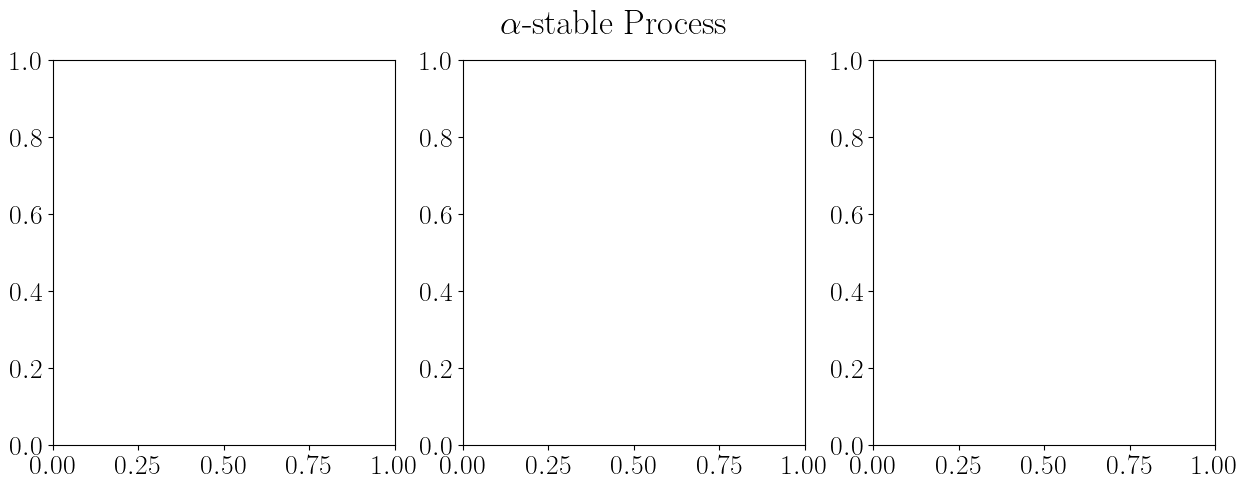

In [2]:
from utility import format_plt, symmetric_stable_scaling_factor, plot_levy_normal_residuals, save_fig, plot_as_process_1d
import matplotlib.pyplot as plt

format_plt()

font_size = 20
format_plt(font_size=font_size)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  
_ = fig.suptitle(r"$\alpha$-stable Process", fontsize=25)


In [6]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.driver import AlphaStableNSMDriver
from stonesoup.models.transition.driven import Process
from scipy.special import gamma as gammafnc
from datetime import datetime, timedelta
import numpy as np

# And the clock starts
start_time = datetime.now().replace(microsecond=0)
seed = 2

alpha = 1.4
noise_case=2
mu_W = 0
sigma_W2 = 1
c=20

as_driver = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=c, alpha=alpha, noise_case=noise_case)
transition_model = Process(cg_driver=as_driver)

timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0], timestamp=timesteps[0])])

num_steps = 10000
for k in range(1, num_steps + 1):
    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

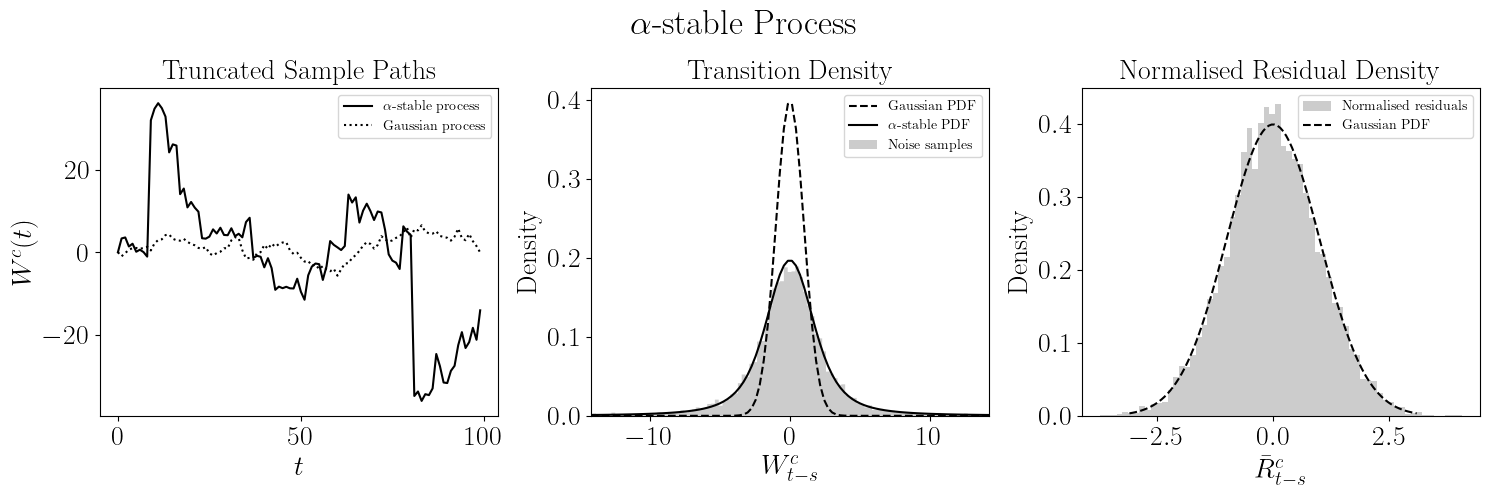

In [34]:
ax1.clear()
title = r"Truncated Sample Paths"
xlabel = r"$t$"
ylabel = r"$W^c(t)$"
figsize = (5, 5)
fig = plot_as_process_1d(fig, ax1, truth=truth[:100], figsize=figsize, alpha=alpha, title=title, xlabel=xlabel, ylabel=ylabel)
fig

In [15]:
# save_fig(fig, "alpha_stable_process")

KS test p-value: 0.16663638969923356


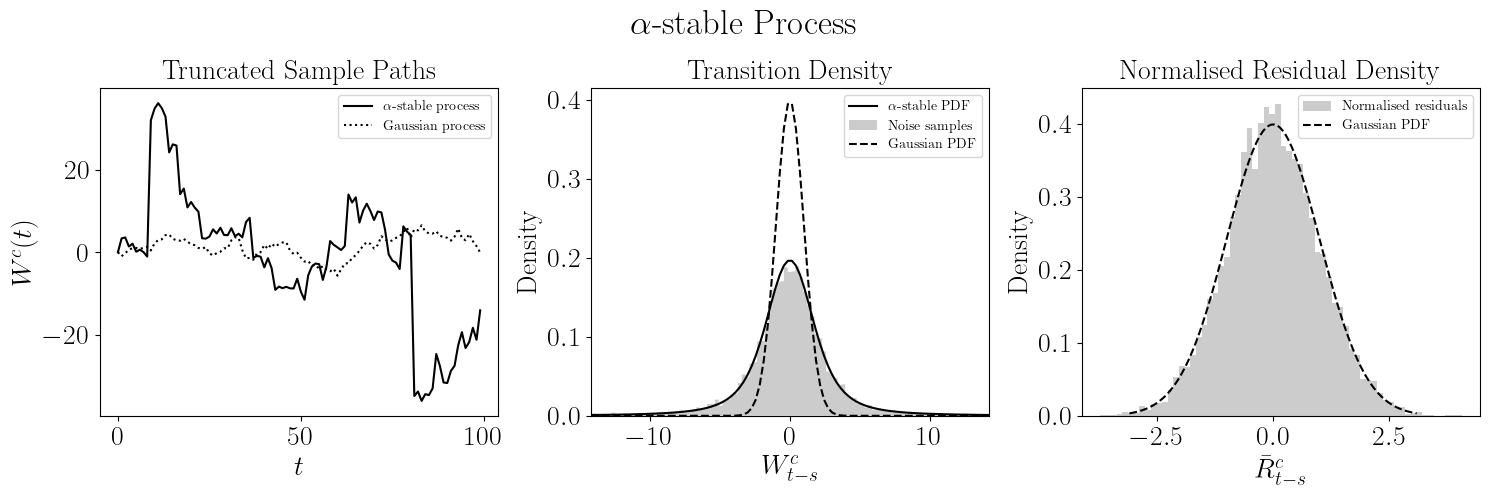

In [35]:
ax2.clear()
title = r"Transition Density"
xlabel = r"$W^c_{t-s}$"
ylabel = r"Density"
fig = plot_levy_normal_residuals(fig, ax2, truth=truth, alpha=alpha, beta=0, sigma_W2=sigma_W2, title=title, xlabel=xlabel, ylabel=ylabel)
fig

In [39]:
# save_fig(fig, "alpha_stable_transition_density")

KstestResult(statistic=0.009079473838167484, pvalue=0.37959919315701807, statistic_location=-0.9063342777807541, statistic_sign=-1)


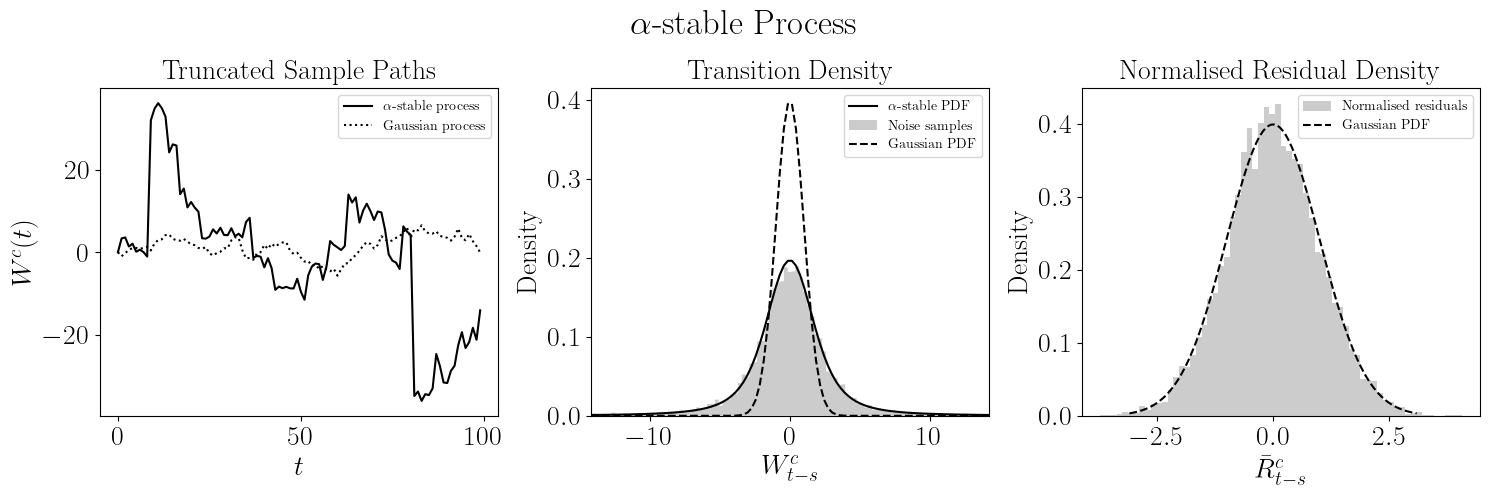

In [36]:
from stonesoup.models.transition.base_driver import Latents
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm, kstest
# Investigate residuals


upper_limit = 100
asd = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, c=upper_limit, alpha=alpha, noise_case=noise_case, seed=seed)
dt = 1
n_latents=10000
ft = lambda dt, jtimes: np.ones_like(jtimes)[..., None, None]
e_ft = lambda dt: dt * np.ones((1, 1))
sizes, times = asd.sample_latents(dt=dt, num_samples=n_latents)
residual_jsizes = sizes[c:]
residual_jtimes = times[c:]
latents = Latents(num_samples=n_latents)
latents.add(asd, residual_jsizes, residual_jtimes)

mean = asd.mean(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents)
covar = asd.covar(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents)
rvs = []
for i in range(n_latents):
    tmp = asd.rvs(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents, covar=covar[i], mean=mean[i], num_samples=1)
    rvs.append(tmp[0])
y = np.array(rvs)
y = (y - y.mean()) / y.std()
results = kstest(y, norm.cdf, N=n_latents) 

ax3.clear()
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
# fig, ax = plt.subplots(nrows=1, ncols=1)  
ax3.hist(y, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color='k', label="Normalised residuals")
ax3.plot(x, norm.pdf(x), '--', label='Gaussian PDF', color='k')    

ax3.set_title(r"Normalised Residual Density")
ax3.set_xlabel(r"$\bar R^c_{t-s}$")
ax3.set_ylabel(r"Density")
ax3.legend()
fig.tight_layout()
 
print(results)
fig


In [37]:
save_fig(fig, "alpha_stable_gather")


In [12]:
# from stonesoup.models.transition.base import CombinedLinearDrivenTransitionModel

# # And the clock starts
# start_time = datetime.now().replace(microsecond=0)
# seed = 1991

# mu_W = 0
# sigma_W2 = 2

# as_driver = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=10, alpha=1.99)
# process_x = Process(cg_driver=as_driver)
# process_y = Process(cg_driver=as_driver)
# transition_model = CombinedLinearDrivenTransitionModel([process_x, process_y])


# timesteps = [start_time]
# truth = GroundTruthPath([GroundTruthState([0, 0], timestamp=timesteps[0])])

# num_steps = 1000
# for k in range(1, num_steps + 1):
#     timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
#     truth.append(GroundTruthState(
#         transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
#         timestamp=timesteps[k]))

In [13]:
# t = np.array([(data.timestamp - start_time).total_seconds() for data in truth])
# t -= t[0]
# y0 = np.array([data.state_vector[0] for data in truth])
# y1 = np.array([data.state_vector[1] for data in truth])

# fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

# ax1.plot(t, y0)
# ax2.plot(t, y1)